# Импорт необходимых библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip -q install transformers datasets
!pip -q install accelerate -U
!pip -q install pymystem3
!pip -q install wordcloud
!pip -q install torcheval

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from pymystem3 import Mystem
from wordcloud import WordCloud

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import pipeline
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torcheval.metrics.functional import multiclass_f1_score
from tqdm import tqdm

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True


# Часть 1. Первичный анализ данных и тематическое моделирование
---





*   **Скачивание датасета**



In [5]:
dataset = load_dataset('MonoHime/ru_sentiment_dataset')
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 189891
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 21098
    })
})

In [6]:
df_train = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['validation'])

In [ ]:
df_train.sample(10)

,Unnamed: 0,text,sentiment
189423,210521,"Впрочем, довольно интересно, что Челябинск - э...",0
9791,30889,Забрели туда в субботу . Ждали мосты . Снача...,0
158628,179726,вот почему то при советской власти такого не б...,0
136841,157939,Очень приличный Отель . Сервис на уровне ! Удо...,1
132617,153715,"Несмотря на ремонт в фойе, персонал умело регу...",0
163069,184167,+ Удобное месторасположение: чуть в глубине от...,0
160833,181931,Прогноз: казахстанские банки станут активнее ...,1
16852,37950,Отношение к пациентам 1. Врачи не вызывают дов...,2
74834,95932,Самое главное - вы находитесь с самом центре с...,1
79488,100586,Хочу поблагодарить врача Спасибо! ОГРОМНОЕ! Ку...,1


*    **EDA**

Общая информация по столбцам

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189891 entries, 0 to 189890
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  189891 non-null  int64 
 1   text        189891 non-null  object
 2   sentiment   189891 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.3+ MB


In [ ]:
df_train.drop(['Unnamed: 0'], axis=1, inplace=True)
df_val.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189891 entries, 0 to 189890
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       189891 non-null  object
 1   sentiment  189891 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ MB


Распределение классов

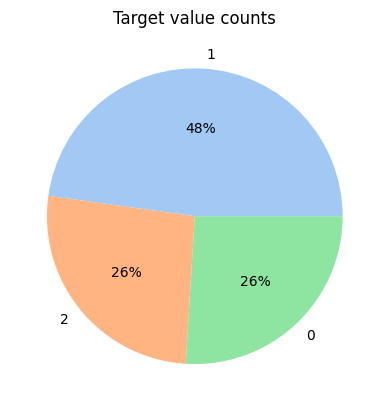

In [ ]:
target_value_counts = df_train['sentiment'].value_counts()
plt.pie(
    target_value_counts,
    labels=target_value_counts.index,
    colors=sns.color_palette('pastel')[0:3],
    autopct='%.0f%%'
)
plt.title('Target value counts')
plt.show()

Средняя длина текста

In [ ]:
df_train['text_len'] = df_train['text'].apply(len)
df_train['text_len'].mean()

800.3200204327746

Самые часто встречающиеся слова

In [ ]:
def most_common_words(df: pd.DataFrame, common_num: int = 10, column: str = 'text') -> list:
  words_counter = Counter()
  for txt in df[column]:
    words_counter.update(txt.split())
  words_counter_items = sorted(words_counter.items(), key=lambda item: item[1], reverse=True)
  return words_counter_items[:common_num]

In [ ]:
most_common_words(df_train)

[('и', 707856),
 ('в', 648247),
 ('не', 415029),
 ('на', 368465),
 (',', 313204),
 ('с', 246837),
 ('что', 236270),
 ('.', 205694),
 ('-', 201351),
 ('по', 138171)]

Уберем стоп-слова и проведем лемматизацию

In [ ]:
ru_stopwords = set(stopwords.words('russian'))
mystem = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
def preprocess_txt(txt: str) -> str:
  tokenized_txt = word_tokenize(txt.lower())
  tokenized_txt = [token for token in tokenized_txt if token not in ru_stopwords and token.isalpha()]
  lemmatized_txt = [mystem.lemmatize(token)[0] for token in tokenized_txt]
  return ' '.join(lemmatized_txt)

In [ ]:
df_train['preprocessed_text'] = df_train['text'].apply(preprocess_txt)

In [ ]:
most_common_words(df_train, column='preprocessed_text')

[('очень', 140588),
 ('это', 140096),
 ('отель', 101532),
 ('год', 85672),
 ('номер', 78471),
 ('который', 77937),
 ('врач', 77365),
 ('хороший', 61587),
 ('все', 53215),
 ('такой', 52698)]

Самые популярные слова по классам

In [ ]:
most_common_words(df_train[df_train['sentiment'] == 0], common_num=20, column='preprocessed_text')

[('это', 43754),
 ('отель', 42297),
 ('номер', 35887),
 ('очень', 33138),
 ('год', 32030),
 ('который', 23048),
 ('хороший', 18108),
 ('завтрак', 14742),
 ('такой', 13810),
 ('день', 12839),
 ('свой', 12348),
 ('казахстан', 12155),
 ('человек', 11870),
 ('один', 11327),
 ('место', 10658),
 ('время', 10597),
 ('самый', 10320),
 ('все', 10244),
 ('наш', 9818),
 ('первый', 9771)]

In [ ]:
most_common_words(df_train[df_train['sentiment'] == 1], common_num=20, column='preprocessed_text')

[('очень', 83666),
 ('это', 58048),
 ('отель', 52155),
 ('врач', 39431),
 ('год', 37571),
 ('спасибо', 37527),
 ('хороший', 34995),
 ('номер', 34298),
 ('который', 32864),
 ('все', 30905),
 ('персонал', 22933),
 ('свой', 22591),
 ('такой', 21620),
 ('день', 21376),
 ('человек', 21018),
 ('большой', 20718),
 ('хотеть', 19317),
 ('наш', 18274),
 ('благодарность', 18089),
 ('просто', 17852)]

In [ ]:
most_common_words(df_train[df_train['sentiment'] == 2], common_num=20, column='preprocessed_text')

[('это', 38294),
 ('врач', 37280),
 ('очень', 23784),
 ('который', 22025),
 ('сказать', 19504),
 ('ребенок', 17631),
 ('такой', 17268),
 ('день', 16825),
 ('год', 16071),
 ('человек', 14754),
 ('свой', 13825),
 ('просто', 13347),
 ('ресторан', 12178),
 ('все', 12066),
 ('время', 12008),
 ('приходить', 11457),
 ('деньги', 11138),
 ('мой', 10893),
 ('клиника', 10296),
 ('наш', 10221)]

* **Тематическое моделирование**

Для тематического моделирования был выбран метод LDA. Данный метод был выбран так как обладает хорошей интерпритируемость, большое количество готовых эффективных и простых в использовании реализаций, а также устойчивость к шуму. В рамках этой работы используется LDA из библиотеки gensim, в качестве улучшения можно использовать различные параметры количества тем или рассмотреть Online LDA для более эффективного обучения модели на большом количестве данных.

In [ ]:
dictionary = corpora.Dictionary(df_train['preprocessed_text'].apply(str.split))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
corpus = [dictionary.doc2bow(doc) for doc in df_train['preprocessed_text'].apply(str.split)]

In [ ]:
ldamodel = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=50)

In [ ]:
for idx, topic in ldamodel.print_topics(-1):
  print(f'Topic: {idx}, words: {topic}')

Topic: 0, words: 0.016*"год" + 0.007*"это" + 0.006*"казахстан" + 0.006*"который" + 0.004*"страна" + 0.003*"тенге" + 0.003*"компания" + 0.003*"также" + 0.003*"развитие" + 0.003*"свой"
Topic: 1, words: 0.022*"отель" + 0.020*"очень" + 0.017*"номер" + 0.009*"это" + 0.008*"хороший" + 0.008*"ресторан" + 0.007*"завтрак" + 0.006*"персонал" + 0.005*"день" + 0.005*"место"
Topic: 2, words: 0.015*"врач" + 0.013*"это" + 0.009*"очень" + 0.007*"спасибо" + 0.006*"такой" + 0.006*"который" + 0.006*"ребенок" + 0.006*"сказать" + 0.006*"человек" + 0.006*"все"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


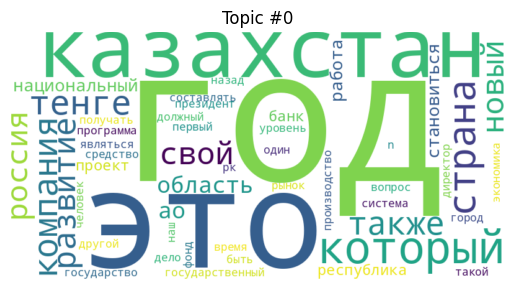

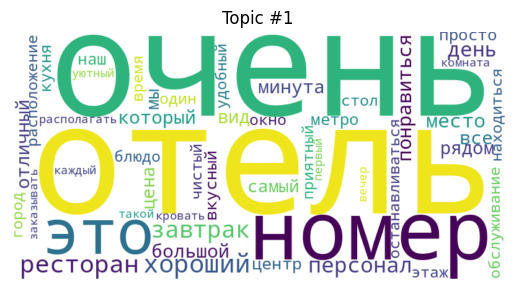

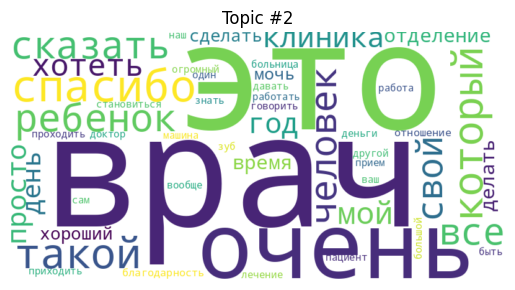

In [ ]:
for t in range(3):
    plt.figure()
    plt.title(f'Topic #{t}')
    topic_words = dict(ldamodel.show_topic(t, topn=50))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Часть 2. Обучение классификатора

В качестве модели была выбрана предобученная модель ruGPT3-small, которая использовалась для извлечения признаков из текстов, в связи с использованием этой модели было решено не предобрабатывать данные, так как данная модель учитывает форму слова и тд. В качестве функции ошибки и оптимизатора были выбраны Cross-Entropy и Adam как стандарты в данной задаче. В качестве метрики качества был выбран F1-score, так как классы не сбалансированы.

In [7]:
class SentimentDataset(Dataset):
  def __init__(self, texts, labels):
    self.texts = texts.to_numpy()
    self.labels = labels.to_numpy()

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]
    return {'text': text, 'label': label}

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_train['text'], df_train['sentiment'], train_size=0.85)
X_val, y_val = df_val['text'], df_val['sentiment']

In [9]:
train_dataset = SentimentDataset(X_train, y_train)
test_dataset = SentimentDataset(X_test, y_test)
val_dataset = SentimentDataset(X_val, y_val)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

In [11]:
class SentimentClassifier(nn.Module):
  def __init__(self, hidden_size: int = 768, output_size: int = 3):
    super().__init__()
    self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    self.feature_extractor = pipeline(task='feature-extraction', model='ai-forever/rugpt3small_based_on_gpt2', device=self.device, truncation=True)
    self.output = nn.Linear(hidden_size, output_size)
    self.softmax = nn.Softmax(dim=1)

  def aggregate_features(self, features: list):
    res = []
    for item in features:
      item_aggregate = np.zeros(768)
      for feature in item[0]:
        item_aggregate += np.array(feature)
      item_aggregate /= 7
      res.append(item_aggregate)
    return res

  def forward(self, X):
    features = self.feature_extractor(X)
    features = torch.FloatTensor(self.aggregate_features(features)).to(self.device)
    output = self.output(features)
    output = self.softmax(output)
    return output

In [12]:
net = SentimentClassifier()
losses = []
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

'cuda:0'

In [13]:
net.to(device)

SentimentClassifier(
  (output): Linear(in_features=768, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [14]:
def compute_metrics(model, device):
  print('===== Compute F1-score =====')
  scores = []
  for batch in tqdm(test_loader):
    X_batch = batch['text']
    y_batch = torch.LongTensor(batch['label']).to(device)
    y_pred = net(X_batch)
    y_pred = torch.argmax(y_pred, dim=1)
    scores.append(multiclass_f1_score(y_pred, y_batch, num_classes=3))
  print('===== Complete =====')
  return scores

In [15]:
num_epochs = 1
net.train()
for epoch in range(num_epochs):
  print(f'===== Epoch {epoch} =====')
  for batch_idx, batch in enumerate(train_loader):
    optimizer.zero_grad()
    X_batch = batch['text']
    y_batch = torch.LongTensor(batch['label']).to(device)
    y_pred = net(X_batch)
    loss = loss_fn(y_pred, y_batch)
    losses.append(loss.data)
    print(f'Batch {batch_idx} - {len(train_loader)}, loss - {loss.data}')
    loss.backward()
    optimizer.step()

Выходные данные были обрезаны до нескольких последних строк (5000).
Batch 44 - 5044, loss - 1.1265366077423096
Batch 45 - 5044, loss - 1.1593918800354004
Batch 46 - 5044, loss - 1.0185699462890625
Batch 47 - 5044, loss - 0.9814462661743164
Batch 48 - 5044, loss - 1.0268205404281616
Batch 49 - 5044, loss - 1.0887950658798218
Batch 50 - 5044, loss - 1.0027999877929688
Batch 51 - 5044, loss - 1.0155303478240967
Batch 52 - 5044, loss - 1.0808048248291016
Batch 53 - 5044, loss - 0.9288769364356995
Batch 54 - 5044, loss - 1.007198452949524
Batch 55 - 5044, loss - 1.1576236486434937
Batch 56 - 5044, loss - 0.9340598583221436
Batch 57 - 5044, loss - 0.8943971991539001
Batch 58 - 5044, loss - 0.9369760751724243
Batch 59 - 5044, loss - 1.0410363674163818
Batch 60 - 5044, loss - 0.9910930395126343
Batch 61 - 5044, loss - 0.9097871780395508
Batch 62 - 5044, loss - 1.051697015762329
Batch 63 - 5044, loss - 0.8872319459915161
Batch 64 - 5044, loss - 1.04148530960083
Batch 65 - 5044, loss - 0.9431487

In [19]:
metric_scores = compute_metrics(net, device)

===== Compute F1-score =====


100%|██████████| 891/891 [20:46<00:00,  1.40s/it]

===== Complete =====


In [23]:
metric_scores = [score.cpu() for score in metric_scores]

In [25]:
np.mean(metric_scores)

0.73151654

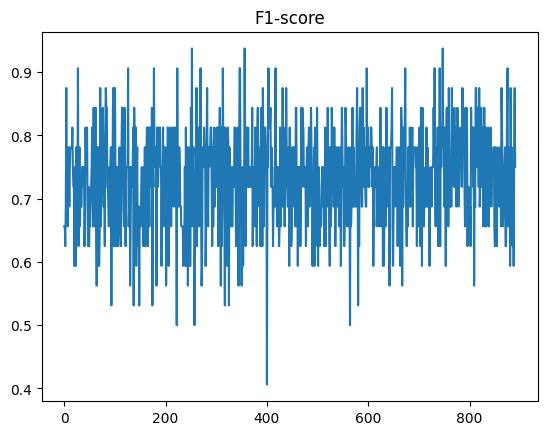

In [26]:
plt.title('F1-score')
plt.plot(metric_scores)